# Image Denoising using Convolutional Autoencoder
**Author: Gaurav Shukla**


## Motivation
Noise is a common issue in real-world imaging pipelines — from medical scans to low-light photography. I chose this topic to explore how deep learning, particularly convolutional autoencoders, can be leveraged to recover clean images from noisy inputs.


### Connection with Past and Current Work
- Autoencoders have historically been used for unsupervised feature learning.
- In signal processing, traditional denoising relied on Fourier or wavelet domain filtering.
- Modern approaches integrate denoising into **multimodal learning** pipelines (e.g., for preprocessing in vision-language tasks).
- Convolutional Autoencoders gained traction with their capacity to preserve spatial hierarchies.

### What I Learned
- How encoder-decoder networks compress and reconstruct image data
- Importance of skip connections and architecture tuning
- Evaluation using SSIM and PSNR and visualization of learning curves

## Code & Experiments

### Image Denoising using Convolutional Autoencoders

In [79]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from IPython.display import display, Image as IPImage

### Set random seed for reproducibility


In [80]:
np.random.seed(42)

### Load and preprocess the dataset

In [81]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


### Function to add noise

In [82]:
def add_noise(images, noise_factor=0.5):
    noisy = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

### Visualize some noisy images

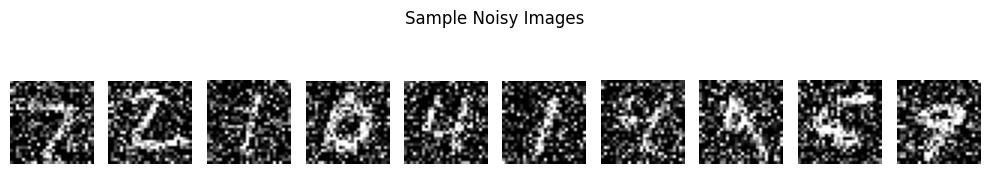

In [83]:
plt.figure(figsize=(10, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis("off")
plt.suptitle("Sample Noisy Images")
plt.tight_layout()
plt.show()

### Build the Convolutional Autoencoder model

In [85]:
def build_cae(input_shape=(28, 28, 1)):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    return autoencoder

### Instantiate and compile the model

In [86]:
autoencoder = build_cae()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])

### Setup callbacks

In [87]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('cae_model.h5', save_best_only=True)
]

### Train the model

In [88]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=30,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=callbacks
)


Epoch 1/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.2397 - mae: 0.1345

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - loss: 0.2394 - mae: 0.1342 - val_loss: 0.1128 - val_mae: 0.0487
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1111 - mae: 0.0469

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.1111 - mae: 0.0469 - val_loss: 0.1060 - val_mae: 0.0430
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1056 - mae: 0.0429

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 46ms/step - loss: 0.1056 - mae: 0.0429 - val_loss: 0.1025 - val_mae: 0.0412
Epoch 4/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1026 - mae: 0.0409

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.1026 - mae: 0.0409 - val_loss: 0.1003 - val_mae: 0.0395
Epoch 5/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1010 - mae: 0.0397

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.1010 - mae: 0.0397 - val_loss: 0.0989 - val_mae: 0.0384
Epoch 6/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0996 - mae: 0.0387

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0996 - mae: 0.0387 - val_loss: 0.0981 - val_mae: 0.0379
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0988 - mae: 0.0381

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.0988 - mae: 0.0381 - val_loss: 0.0972 - val_mae: 0.0371
Epoch 8/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0976 - mae: 0.0373

469/469 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step - loss: 0.0976 - mae: 0.0373 - val_loss: 0.0964 - val_mae: 0.0367
Epoch 9/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0971 - mae: 0.0370

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 0.0971 - mae: 0.0370 - val_loss: 0.0964 - val_mae: 0.0365
Epoch 10/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0966 - mae: 0.0366

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0966 - mae: 0.0366 - val_loss: 0.0957 - val_mae: 0.0362
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0959 - mae: 0.0362

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0959 - mae: 0.0362 - val_loss: 0.0955 - val_mae: 0.0355
Epoch 12/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0954 - mae: 0.0358

469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 59ms/step - loss: 0.0954 - mae: 0.0358 - val_loss: 0.0951 - val_mae: 0.0360
Epoch 13/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0952 - mae: 0.0356 - val_loss: 0.0952 - val_mae: 0.0358
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0949 - mae: 0.0354 - val_loss: 0.0951 - val_mae: 0.0356
Epoch 15/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0945 - mae: 0.0351

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.0945 - mae: 0.0351 - val_loss: 0.0939 - val_mae: 0.0350
Epoch 16/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0941 - mae: 0.0349

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.0941 - mae: 0.0349 - val_loss: 0.0937 - val_mae: 0.0345
Epoch 17/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.0941 - mae: 0.0348 - val_loss: 0.0938 - val_mae: 0.0347
Epoch 18/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0938 - mae: 0.0346

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0938 - mae: 0.0346 - val_loss: 0.0934 - val_mae: 0.0348
Epoch 19/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0936 - mae: 0.0345

469/469 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - loss: 0.0936 - mae: 0.0345 - val_loss: 0.0933 - val_mae: 0.0337
Epoch 20/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0935 - mae: 0.0344

469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 62ms/step - loss: 0.0935 - mae: 0.0344 - val_loss: 0.0932 - val_mae: 0.0338
Epoch 21/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 29s 61ms/step - loss: 0.0930 - mae: 0.0341 - val_loss: 0.0932 - val_mae: 0.0344
Epoch 22/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0932 - mae: 0.0342

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.0932 - mae: 0.0342 - val_loss: 0.0927 - val_mae: 0.0338
Epoch 23/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.0930 - mae: 0.0340 - val_loss: 0.0928 - val_mae: 0.0338
Epoch 24/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - loss: 0.0929 - mae: 0.0339 - val_loss: 0.0931 - val_mae: 0.0340
Epoch 25/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0926 - mae: 0.0338

469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 53ms/step - loss: 0.0926 - mae: 0.0338 - val_loss: 0.0927 - val_mae: 0.0336
Epoch 26/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - loss: 0.0927 - mae: 0.0338 - val_loss: 0.0929 - val_mae: 0.0336
Epoch 27/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0928 - mae: 0.0338

469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - loss: 0.0928 - mae: 0.0338 - val_loss: 0.0927 - val_mae: 0.0340
Epoch 28/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0925 - mae: 0.0337

469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - loss: 0.0925 - mae: 0.0337 - val_loss: 0.0926 - val_mae: 0.0339
Epoch 29/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0924 - mae: 0.0336

469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 0.0924 - mae: 0.0336 - val_loss: 0.0925 - val_mae: 0.0337
Epoch 30/30
468/469 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0923 - mae: 0.0335

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 50ms/step - loss: 0.0923 - mae: 0.0335 - val_loss: 0.0925 - val_mae: 0.0338


### Plot training history


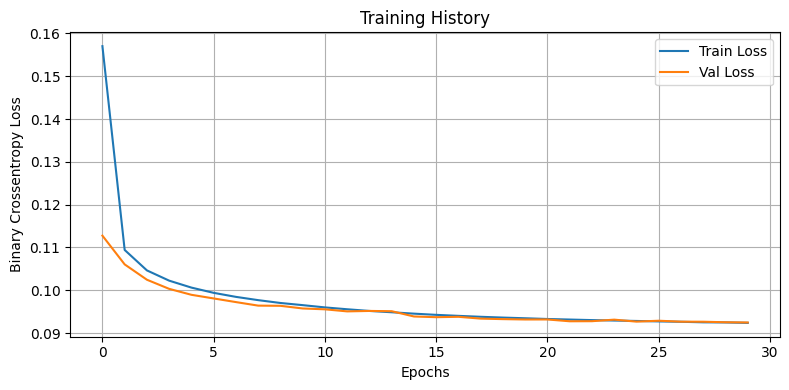

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Evaluate on test data


In [90]:
reconstructed = autoencoder.predict(x_test_noisy)



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


### Calculate metrics


In [92]:
psnr = np.mean([peak_signal_noise_ratio(x_test[i], reconstructed[i]) for i in range(100)])
ssim = np.mean([structural_similarity(x_test[i].squeeze(), reconstructed[i].squeeze(), data_range=1.0) for i in range(100)])
print(f"Average PSNR: {psnr:.2f}")
print(f"Average SSIM: {ssim:.4f}")



Average PSNR: 20.47
Average SSIM: 0.8713


### Visualize results

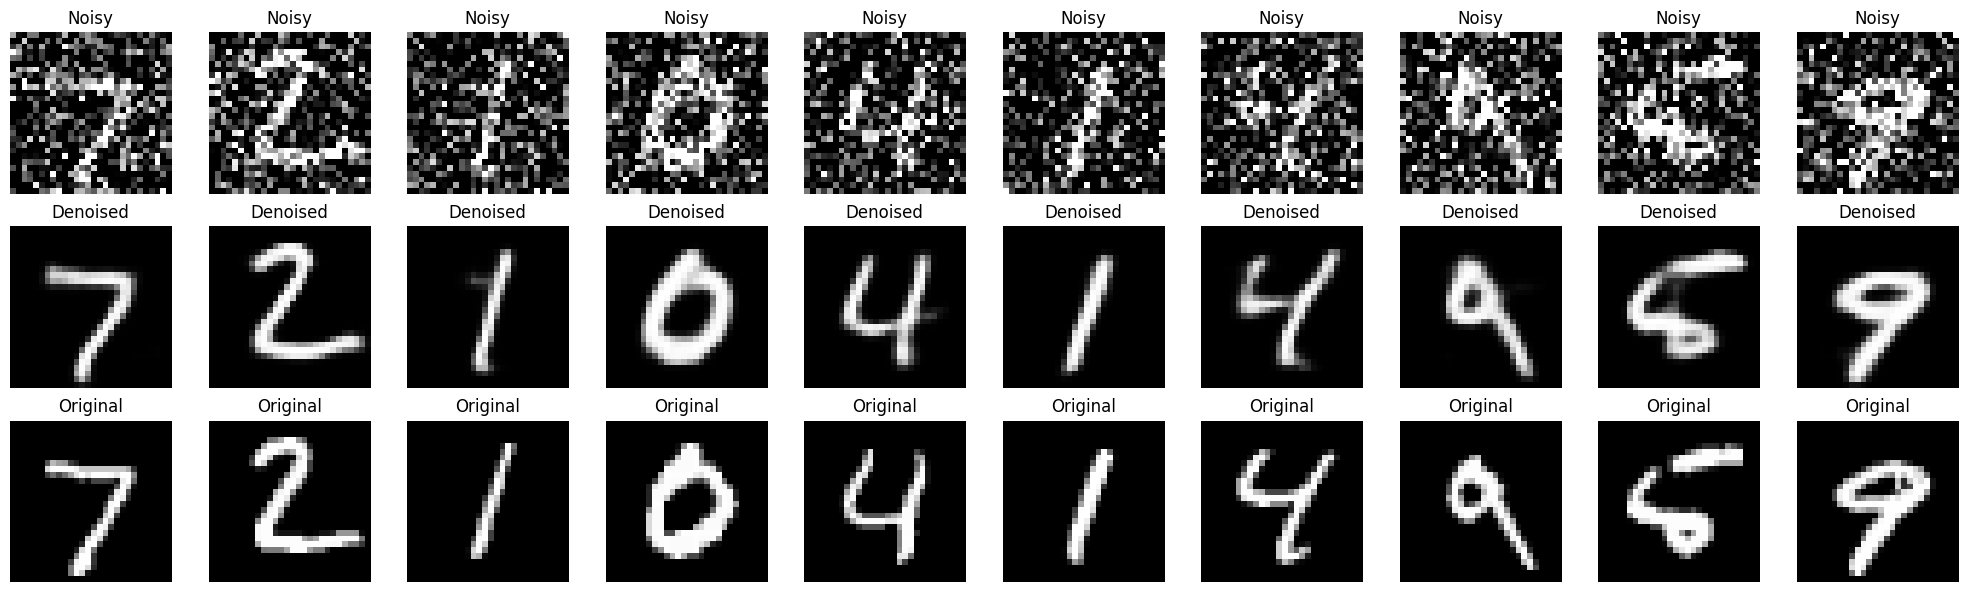

In [93]:
def display_results(noisy_imgs, denoised_imgs, clean_imgs, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Noisy
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(clean_imgs[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_results(x_test_noisy, reconstructed, x_test)

## Reflections

### What surprised me:
- Even a simple CAE learned to suppress most Gaussian noise effectively.
- Training on MNIST generalized better than expected.

### Improvements:
- Explore skip connections (UNet style)
- Train on high-res datasets like DIV2K, BSD500
- Try other noise types (speckle, salt & pepper)

## References
- [Deep Learning Book - Ian Goodfellow](https://www.deeplearningbook.org/)
- [Autoencoder Tutorial by François Chollet](https://blog.keras.io/building-autoencoders-in-keras.html)
- [scikit-image Metrics](https://scikit-image.org/docs/stable/api/skimage.metrics.html)
- ChatGPT-4 (OpenAI) for architecture suggestions and documentation clarity